In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_feature.f')
print(test_.shape)

(8359, 1449)
(8360, 1444)


In [3]:
n_fold = 5

In [4]:
train_.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,level_2,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,...,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9,LDA_Developer_0,LDA_Developer_1,LDA_Developer_2,LDA_Developer_3,LDA_Developer_4,LDA_Developer_5,LDA_Developer_6,LDA_Developer_7,LDA_Developer_8,LDA_Developer_9
0,LEGO Batman: The Videogame,23,0,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,454,1,0,8.0,7.0,3.135494,2010.0,0.0,1320,3370,235,237,1420,2830,2019,93.604962,61.883755,49.257785,106.536082,49.231678,59.678899,52.633663,56.848214,289.223684,112.428571,64.319444,81.140351,48.326531,50.646154,56.630137,444.419232,148.275892,72.187084,341.484617,73.847985,96.258706,76.873366,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000142,0.646504,0.000142,0.000142,0.000142,0.000142,0.215263,0.000142,0.000142,0.137241,0.253986,0.009533,0.093858,0.014429,0.583834,0.000141,0.002977,0.04096,0.000141,0.000141
1,LEGO Indiana Jones: The Original Adventures,23,0,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,454,1,0,7.0,8.0,3.367296,2008.0,0.0,1320,3370,90,237,1420,1634,2366,96.597250,58.394680,49.148789,66.403374,101.466970,54.090000,48.867470,52.439815,213.160000,54.335079,58.293233,483.589744,89.802260,75.231343,96.758065,462.863031,120.188797,75.206074,174.818593,341.906251,91.001509,72.338596,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.515379,0.000369,0.045018,0.000369,0.104447,0.000369,0.188290,0.000369,0.000369,0.145019,0.253986,0.009533,0.093858,0.014429,0.583834,0.000141,0.002977,0.04096,0.000141,0.000141
2,LEGO Batman: The Videogame,17,0,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,454,1,0,7.0,7.0,2.397895,2010.0,0.0,1209,3370,235,237,1420,1634,2019,29.606403,59.681720,53.568595,64.981846,46.931655,48.185714,53.033898,58.454936,31.886792,58.615789,60.314286,45.701493,47.107692,53.884615,57.709821,69.859005,132.194405,81.714638,150.222097,77.663440,114.136366,82.460642,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000142,0.646504,0.000142,0.000142,0.000142,0.000142,0.215263,0.000142,0.000142,0.137241,0.253986,0.009533,0.093858,0.014429,0.583834,0.000141,0.002977,0.04096,0.000141,0.000141
3,Combat,0,0,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,497,6,0,NaN,NaN,NaN,1982.0,NaN,133,3370,367,1127,6769,9129,8582,65.943662,62.435252,NaN,NaN,NaN,52.269231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,149.649097,NaN,NaN,NaN,49.684249,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [5]:
test_.head()

,Name,Platform,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,level_2,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,TGE_Global_Sales_std_by_User_Score_int_Platform,TGE_Global_Sales_std_by_User_Score_int_Genre,TGE_Global_Sales_std_by_User_Score_int_Rating,TGE_Global_Sales_std_by_Critic_Score_int_Platform,...,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9,LDA_Developer_0,LDA_Developer_1,LDA_Developer_2,LDA_Developer_3,LDA_Developer_4,LDA_Developer_5,LDA_Developer_6,LDA_Developer_7,LDA_Developer_8,LDA_Developer_9
0,Hitman 2: Silent Assassin,26,0,Eidos Interactive,84.0,23.0,8.0,19.0,238,3,0,8.0,8.0,2.995732,2004.0,0.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,34.246377,90.017778,88.489083,111.091346,64.594512,139.218459,203.600983,320.473808,323.717868,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,44.125958,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.633611,0.000168,0.181229,0.000168,0.020847,0.000168,0.043707,0.000168,0.000168,0.119765,0.001640,0.258052,0.050083,0.001640,0.316334,0.001640,0.001639,0.365693,0.001639,0.001640
1,Legacy of Kain: Soul Reaver,13,0,Eidos Interactive,91.0,17.0,9.0,132.0,119,5,0,9.0,9.0,4.890349,1999.0,0.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,51.920228,325.000000,156.375000,104.608491,412.666667,190.612903,164.576923,215.804348,129.886997,139.218459,99.850190,235.111932,327.145440,108.623828,289.354320,96.611679,360.629311,287.232653,191.872644,328.886578,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.633611,0.000168,0.181229,0.000168,0.020847,0.000168,0.043707,0.000168,0.000168,0.119765,0.001317,0.001316,0.061174,0.001316,0.419612,0.001316,0.028028,0.483290,0.001316,0.001316
2,Metal Gear Solid 2: Substance,26,0,Konami Digital Entertainment,87.0,28.0,8.5,39.0,499,3,0,8.0,9.0,3.688879,2004.0,0.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,57.935484,190.612903,201.981308,201.214689,64.594512,139.218459,203.600983,320.473808,327.145440,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,52.441037,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.072509,0.107085,0.032553,0.111393,0.096406,0.000040,0.011211,0.407121,0.161643,0.002703,0.002704,0.002704,0.002705,0.002704,0.065768,0.078295,0.542960,0.002704,0.296753
3

In [6]:
lgbm_param = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
#     'lambda_l1': 1.9090472958000438e-07, 
#     'lambda_l2': 1.3091776726058165e-07, 
#     'num_leaves': 64, 
#     'feature_fraction': 0.5, 
#     'bagging_fraction': 1.0, 
#     'bagging_freq': 0, 
#     'min_child_samples': 20,
    'max_depth': 6,
    'colsample_bytree': .5,
    'importance_type': 'gain',
    'verbose': -1
}

In [7]:
def tuning_lgbm(X, y, group, params, verbose=100):
    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    tr_group_idx, va_group_idx = list(cv)[4]
        
    train_groups = unique_group[tr_group_idx]
    valid_groups = unique_group[va_group_idx]
    is_train = group.isin(train_groups)
    is_valid = group.isin(valid_groups)
        
    x_train, y_train = X[is_train], y[is_train]
    x_valid, y_valid = X[is_valid], y[is_valid]
    
    lgbm_train = lgbm.Dataset(x_train, y_train)
    lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
    
    best_params, tuning_history = dict(), list()
    best = lgbm.train(params,
                                  lgbm_train,
                                  valid_sets=lgbm_eval,
                                  num_boost_round=10000,
                                  early_stopping_rounds=verbose,
                                  verbose_eval=0)
    print('Best Params:', best.params)
    print('Best Iteration:', best.best_iteration)
    print('Best Score:', best.best_score)

In [8]:
# y = train_['Global_Sales'].apply(np.log1p)
# group = train_['Publisher'].copy()
# train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
# tuning_lgbm(train_, y, group, lgbm_param)

In [9]:
def train_lgbm(X, y, group, params: dict, verbose=100):

    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = list(fold.split(X)) 
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[idx_valid] = y_pred
        models.append(lgbm_model)
        print('--- Fold {} Score: {:.4f} ---'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('--- FINISHED \ whole score: {:.4f} ---'.format(score))
    return oof_pred, models, score

In [10]:
def train_lgbm_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[is_valid] = y_pred
        models.append(lgbm_model)
        print('--- Fold {} Score: {:.4f} ---'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('--- FINISHED \ whole score: {:.4f} ---'.format(score))
    return oof_pred, models, score

In [11]:
def train_pred(train_df, y, test_df, group):
    oof, models, score = train_lgbm_group(train_df, y, group, lgbm_param)
    
    pred_list = []
    for i, model in enumerate(models):
            pred = model.predict(test_df, num_iteration = model.best_iteration)
            pred = np.expm1(pred)
            
            pred_list.append(pred)
            print(i, pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [12]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [13]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

x_train (6174, 1442)
x_valid (2185, 1442)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 1.31325
--- Fold 0 Score: 1.3133 ---
x_train (7540, 1442)
x_valid (819, 1442)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 0.918078
--- Fold 1 Score: 0.9181 ---
x_train (5807, 1442)
x_valid (2552, 1442)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
Early stopping, best iterat

In [14]:
feature_importance(models).head(50)

,name,imp_0,imp_1,imp_2,imp_3,imp_4,sum
1441,Year,63,163,96,149,216,687
1440,User_Count,45,99,67,92,127,430
1435,TGE_Global_Sales_mean_by_Platform_Genre,15,87,31,85,89,307
1439,User_Count_log,40,55,51,40,61,247
1438,TGE_Global_Sales_std_by_Platform_Genre,18,54,33,50,88,243
1437,Critic_Count,16,44,29,48,64,201
1400,TGE_Global_Sales_mean_by_Platform,8,42,22,44,70,186
1401,TGE_Global_Sales_mean_by_Genre,8,36,17,52,60,173
1416,LDA_Developer_3_by_Platform,10,38,23,35,45,151
1422,TGE_Global_Sales_std_by_Platform,11,31,9,47,43,141


In [15]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 22.784230722331422
max= 518.6650745008568


Text(0.5, 0, 'Global_Sales')

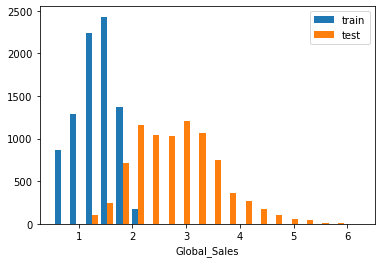

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [17]:
FILENAME = 'submission_lgbm.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_lgbm.csv


In [18]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- lgbm = {:.4f}'.format(score))

- feat = 1442
- mean = 22.7842
- max = 518.6651
- lgbm = 1.0448


### ensumble

In [19]:
lgbm_out = pd.read_csv('../outputs/submission_lgbm.csv').rename(columns={'Global_Sales': 'lgbm'})
cat_out = pd.read_csv('../outputs/submission_cat.csv').rename(columns={'Global_Sales': 'cat'})
ensumble = pd.concat([lgbm_out, cat_out], axis=1)
ensumble['Global_Sales'] = (ensumble['lgbm']*0.7 + ensumble['cat']*0.3)
ensumble.drop(columns=['lgbm', 'cat'], inplace=True)
assert len(ensumble) == len(test_)
ensumble.to_csv('../outputs/submission.csv', index=False)

print('- mean = {:.4f}'.format(ensumble['Global_Sales'].mean()))
print('- max = {:.4f}'.format(ensumble['Global_Sales'].max()))

- mean = 22.5098
- max = 477.6824


#### 26: lgbm: Developer-LDA
- feat = 1442
- mean = 22.7842
- max = 518.6651
- lgbm = 1.0448 (lr=0.1, max_depth=6)
- LB= 0.9113

#### 25-1: lgbm: Year, Devloper
- feat = 1432
- mean = 26.3477
- max = 474.2778
- lgbm = 1.0517 (lr=0.1, max_depth=6)
- LB= 0.909

#### 25: lgbm: Year, Devloper
- feat = 1432
- mean = 26.7352
- max = 525.9232
- lgbm = 1.0468 (lr=0.1, max_depth=4)
- LB= 0.9173

#### 24: lgbm: model=0を除く
- feat = 1432
- mean = 26.7077
- max = 637.1708
- lgbm = 1.1164 (lr=0.1)
- LB= 0.9107

#### 23: lgbm(0.7)+cat(0.3) Sales_Rank
- feat = 1452
- mean = 17.3757
- max = 332.1963
- lgbm = 1.0195 (lr=0.05)
- cat = 1.0367
- LB= 1.0246

#### 22: lgbm(0.7)+cat(0.3) Publisher-LDA
- feat = 1432
- mean = 26.4448
- max = 536.7920
- lgbm = 1.0752
- cat =  1.0980
- LB= 0.8911　★best★

#### 21: ensumble
- lgbm = 0.8935
- cat = 0.9055
- LB = 0.8947

#### 21: lgbm (11相当)
- feat = 1421
- mean = 25.9600
- max = 531.4130
- score = 1.0630
- LB= 0.8935
